In [175]:
## In this notebook we attempt to solve the 2D heat equation
# once we do this we can extrapolate to n dimensions
# main difference should be how we construct training set

# import packages
import torch # pytorch
import torch.nn as nn # neural nets
import numpy as np # math
import matplotlib.pyplot as plt # plotting

# SEED
np.random.seed(0)

# Define network
class Heat_PINN(nn.Module):
    def __init__(self,hidden_units):
        super().__init__()
        
        # Parameters
        self.hidden_units = hidden_units # number of nodes in hidden layer
        
        # layers - assume for now tanh activation, but may need to change
        self.net = nn.Sequential(
            nn.Linear(3, hidden_units), # 3 inputs: x, y, and t
            nn.Tanh(),
            nn.Linear(hidden_units, hidden_units),
            nn.Tanh(),
            nn.Linear(hidden_units, 1) # 1 output, u
        )

    def forward(self, x, y, t):
        return self.net(torch.cat([x, y, t], dim=1))


# Function measuring the collocation residual operator using autograd
def heat_residual(model, x, y, t):
    x.requires_grad_(True)
    y.requires_grad_(True)
    t.requires_grad_(True)
    
    u = model(x, y, t)
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True)[0]
    
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u), create_graph=True)[0]
    
    return u_t - (u_xx+u_yy)

## Now we will initialize our training data:
# will need to output all spatial data in one array, so find way to concatenate? Later separate in the training function

def MakeTrainingData(T,L,N_I,N_B,N_L):
    # PDE parameters
    #T = 1 # time domain end
    #L = 1 # domain size -- start w/ 1 but eventually go to [-L,L]
    
    # First set data sizes
    #N_I = 100 #initial condition
    #N_B = 100 #boundary conditions
    #N_L = 1000 #collocation points
    
    # Initial data: function g(x) and time 0
    x_I = torch.rand(N_I,1) # initial x, spaced evenly
    y_I = torch.rand(N_I,1)
    t_I = torch.zeros_like(x_I) # t = 0
    #y_I = torch.stack([x_I,x_I],0) # CREATE TWO COPIES TO REPRESENT X AND Y
    #print(x_I)
    g = torch.sin(np.pi*x_I) * torch.sin(np.pi*y_I) # initial data
    #plt.plot(x_I,g) # shows plot of initial data
    
    # Boundary data - should have four combos of x=0,1 and y=0,1, and t values copied for each
    # MAKE SURE N_B LARGE ENOUGH TO BE DIVISIBLE BY 4!!!!!! (think >= 12)
    x_B = torch.zeros(N_B).reshape(-1,1) # first half are zeros
    x_B[N_B//2:] = 1 # second half are ones
    y_B = torch.zeros(N_B//2).reshape(-1,1) # first and third quarter zeros
    y_B[N_B//4:] = 1 # second quarter zeros
    y_B = torch.cat([y_B,y_B],0) # copy to get all combos
    #print(x_B)
    t_B = torch.rand(N_B//4,1)*T #one set of t values
    t_B = torch.cat([t_B,t_B,t_B,t_B],0) #copy four times and put together
    #print(t_B)
    D_B = torch.zeros_like(t_B) # Dirichlet boundary conditions
    #print(D_B)
    
    # Collocation data
    x_L = torch.rand(N_L,1)*L # use for [0,1] or [0,L]
    y_L = torch.rand(N_L,1)*L # use for [0,1] or [0,L]
    #x_L = (torch.rand(N_L,1)*2*L)-L # USE IF [-L,L]
    t_L = torch.rand(N_L,1)*T # random time points
    #print(x_L)
    #plt.plot(x_L)

    return x_I, y_I, t_I, g, x_B, y_B, t_B, D_B, x_L, y_L, t_L


## Here we define our loss function

# first set weights for each loss component
w_I = 1
w_B = 1
w_L = 1

## DEFINE ALLOWING FOR ANY SUBSET OF x's TO BE INPUTTED
def Loss(xi,yi,ti,ui,xb,yb,tb,ub,xl,yl,tl,model,p):
    # do initial, boundary, collocation one by one
    # Initial
    u_I = model(xi,yi,ti)
    loss_I = torch.mean((u_I-ui)**2) # MSE for initial data, comparing to g

    # Boundary
    u_B = model(xb,yb,tb)
    loss_B = torch.mean((u_B-ub)**2) # MSE for boundary, comparing to Dirichlet

    # Collocation
    loss_L = torch.mean(heat_residual(model,xl,yl,tl)**2)

    #if p == 1:
    #    print(f"Initial Loss: {loss_I}")
    #    print(f"Boundary Loss: {loss_B}")
    #    print(f"Collocation Loss: {loss_L}")

    # Add up losses, making sure to weight:
    return w_I*loss_I + w_B*loss_B + w_L*loss_L
    


## Funtion that runs training:

# include batches
def train(model, optimizer, max_epochs, N_I, N_B, N_L, batch_size_I, batch_size_B, batch_size_L, tol, print_epochs):
    # INPUTS:
    # model = neural network
    # optimizer = thing running gradient descent, we will use SGD
    # max_epochs = maximum number of iterations
    # tol = error tolerance
    # print_epochs = specifies if we want epochs printed

    T = 1
    L = 1

    x_I, y_I, t_I, g, x_B, y_B, t_B, D_B, x_L, y_L, t_L = MakeTrainingData(T,L,N_I,N_B,N_L) # initiate training data
    #print(len(x_I))

    # Set SGD batch sizes
    Nbatch_I, Nbatch_B, Nbatch_L = batch_size_I, batch_size_B, batch_size_L

    for epoch in range(max_epochs):
        # randomize batches
        indices_I = torch.randperm(N_I)[:Nbatch_I]
        xi = x_I[indices_I]
        yi = y_I[indices_I]
        ti = t_I[indices_I]
        ui = g[indices_I]

        indices_B = torch.randperm(N_B)[:Nbatch_B]
        xb = x_B[indices_B]
        yb = y_B[indices_B]
        tb = t_B[indices_B]
        ub = D_B[indices_B]

        indices_L = torch.randperm(N_L)[:Nbatch_L]
        xl = x_L[indices_L]
        yl = y_L[indices_L]
        tl = t_L[indices_L]
        
        
        #outputs = model(X) # Forward pass
        optimizer.zero_grad() # Clear gradients
        loss = Loss(xi,yi,ti,ui,xb,yb,tb,ub,xl,yl,tl,model,print_epochs) # print epochs passes to loss    
        loss.backward() # Backpropagation
        optimizer.step() # Update weights
        
        if print_epochs == 1:
            if epoch % (max_epochs // 10) == 0:
                print(f"Epoch [{epoch}/{max_epochs}], Loss: {loss.item():.4f}")

        if loss < tol:
            print(f"Network converged to specified tolerance tol = {tol}")
            print(f"Final epoch: {epoch}")
            break

In [177]:
## LETS TRY THE NETWORK AND PRAY!!!!

## RUN TRAINING!!!!!
# initialize model
hidden_units = 100
model = Heat_PINN(hidden_units)

# select an optimizer, will use SGD: 
lr = 1e-3 # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr)

# training data parameters
N_I = 1000
N_B = 1000
N_L = 10000

# training parameters
max_epochs = 20000 # maximum number of iterations
tol = 1e-4 # error tolerance to stop GD before reaching max_epochs
batch_size_I = N_I//5
batch_size_B = N_B//5
batch_size_L = N_L//10



train(model, optimizer, max_epochs, N_I, N_B, N_L, batch_size_I, batch_size_B, batch_size_L, tol, 1)

Epoch [0/20000], Loss: 0.2601
Epoch [2000/20000], Loss: 0.0232
Epoch [4000/20000], Loss: 0.0108
Epoch [6000/20000], Loss: 0.0069
Epoch [8000/20000], Loss: 0.0037
Epoch [10000/20000], Loss: 0.0022
Epoch [12000/20000], Loss: 0.0014
Epoch [14000/20000], Loss: 0.0018
Epoch [16000/20000], Loss: 0.0030
Epoch [18000/20000], Loss: 0.0008


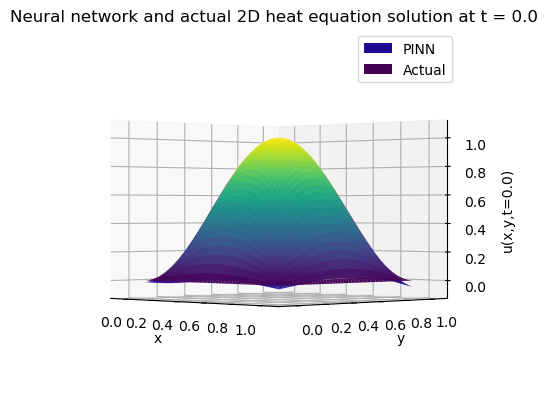

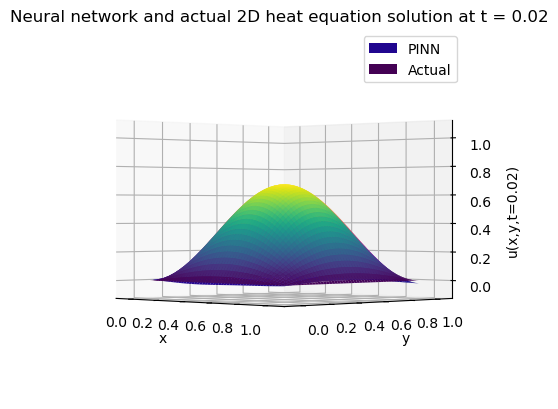

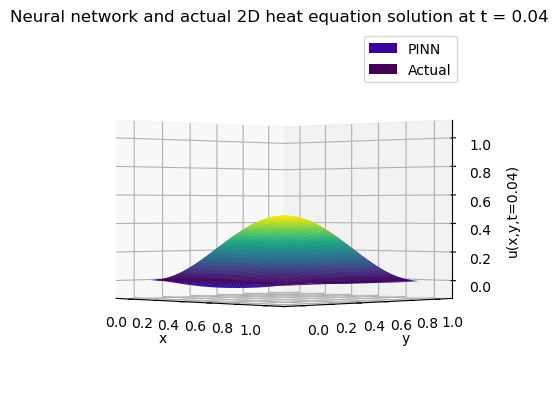

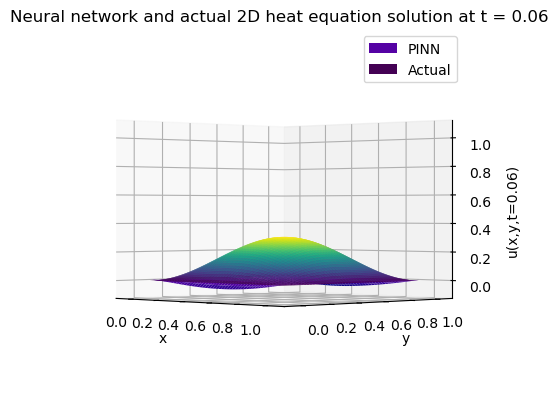

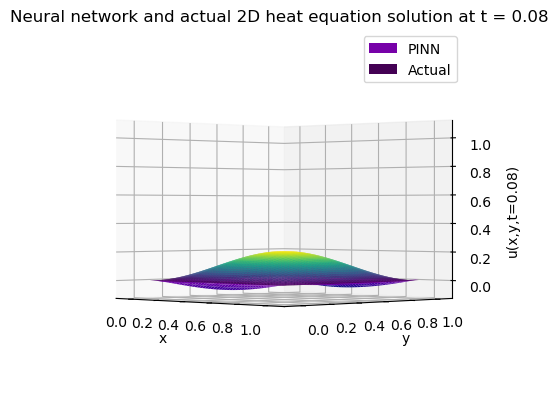

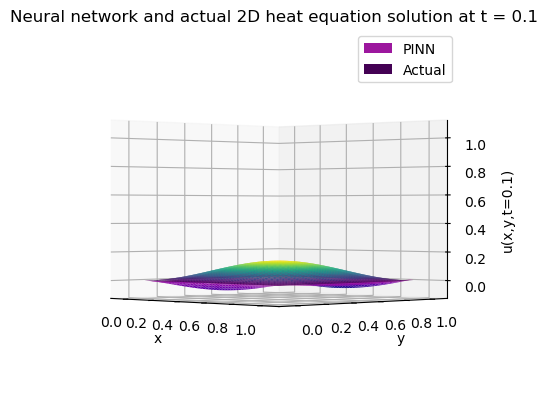

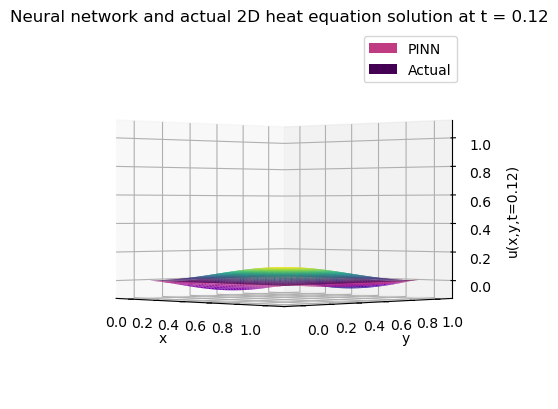

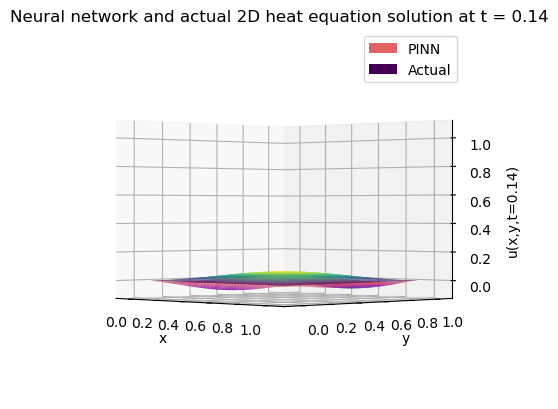

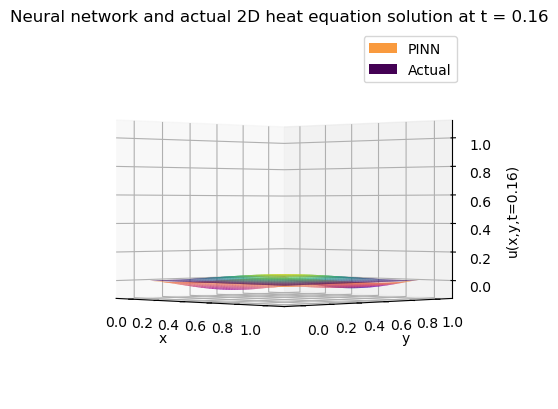

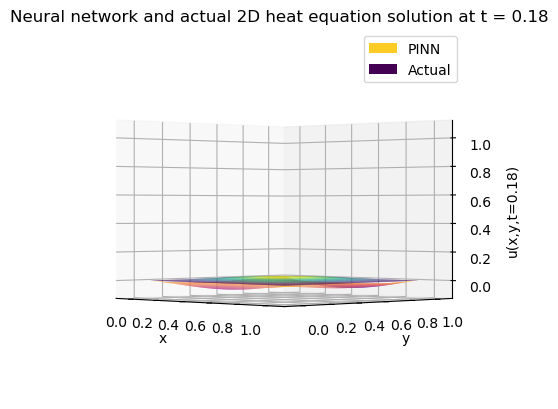

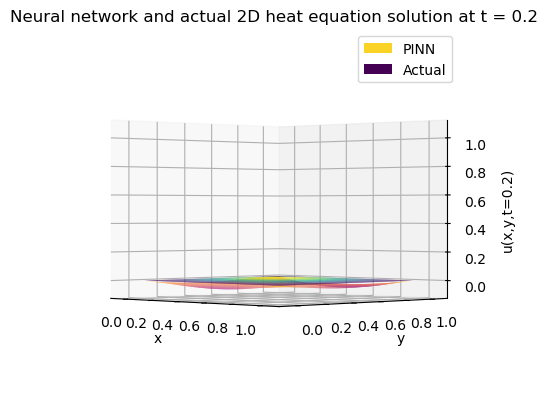

In [179]:
## Plot many time steps to compare to actual solution
from mpl_toolkits.mplot3d import Axes3D # for 3D axes?

x_test = torch.linspace(0,1,100).reshape(-1,1)
y_test = torch.linspace(0,1,100).reshape(-1,1)
x_plot,y_plot = np.meshgrid(x_test,y_test)

for k in np.linspace(0,.2,11):
    X = torch.from_numpy(x_plot.reshape(-1,1))
    Y = torch.from_numpy(y_plot.reshape(-1,1))
    t_test = torch.full_like(X,k)

    # evaluate model
    u_pred = model(X,Y,t_test)

    # actual
    u_actual = np.exp(-2*np.pi**2 * t_test.detach().numpy().reshape(-1,100)) * np.sin(np.pi * x_plot) * np.sin(np.pi * y_plot)

    # make plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x_plot, y_plot, u_pred.detach().numpy().reshape(-1,100), cmap='plasma', label = 'PINN')
    surf = ax.plot_surface(x_plot, y_plot, u_actual, cmap='viridis', label = 'Actual')
    # U.detach().numpy().reshape(-1,100) puts U in the proper form to apply surf plot
        
    # Add a color bar
    #fig.colorbar(surf)
    plt.xlabel("x")
    plt.ylabel("y")
    ax.set_zlabel(f"u(x,y,t={k})")
    plt.title(f"Neural network and actual 2D heat equation solution at t = {k}")
    ax.view_init(0, -45) # default elev=30, azim=-60
    plt.legend()
    ax.set_xlim3d(-.1, 1.1)  # Set x-axis limits from 0 to 6
    ax.set_ylim3d(-.1, 1.1)  # Set y-axis limits from 0 to 6
    ax.set_zlim3d(-.1, 1.1)
    #plt.grid(True)
    plt.show()

# LOOK SIMILAR BUT DEFINITELY ERROR IN PINN SOLUTION AS T INCREASES






In [181]:
## Compute error residual

def NN_residual():
    # define x, y, and t grid values, carefule to track tensor vs grid values
    x_test = torch.linspace(0,1,100).reshape(-1,1)
    y_test = torch.linspace(0,1,100).reshape(-1,1)
    x_plot,y_plot = np.meshgrid(x_test,y_test)
    X = torch.from_numpy(x_plot.reshape(-1,1))
    Y = torch.from_numpy(y_plot.reshape(-1,1))

    t = torch.linspace(0, 1, 100).reshape(-1, 1) # have as many time steps as we want
    
    # list comprehension evaluates model for all x at each time value
    U = torch.stack([model(X,Y,torch.ones_like(X)*n) for n in t])
    print(np.size(U.detach().numpy()))


    t_full = torch.cat([torch.ones_like(t)*q for q in t],0).reshape(-1,100)

    # now compare to actual
    U = U.detach().numpy().reshape(-1,100,100)
    U_actual = [np.exp(-2*np.pi**2 * q.detach().numpy().reshape(-1,100)) * np.sin(np.pi * x_plot) * np.sin(np.pi * y_plot) for q in t_full]
    #U_actual = np.exp(-np.pi**2 * t) * np.sin(np.pi * x)

    U_res = U - U_actual
    #return np.linalg.norm(U_res,np.inf) # max row sum
    #return np.max(np.abs(U_resNN)) # max single value
    return np.mean(U_res**2)

    #return U_res

NN_residual()

1000000


0.00030008442